# Importing the required libraries

In [ ]:
!sudo apt update

In [ ]:
!sudo apt install libsasl2-dev libsasl2-2 libsasl2-modules-gssapi-mit sasl2-bin libsasl2-2 libsasl2-dev libsasl2-modules -y

In [9]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 564.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 kB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 2.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import plotly_express as px
import warnings
from pandas.plotting import lag_plot
from datetime import datetime
import statsmodels.api as sm
from sklearn.metrics import *
from pandas_profiling import ProfileReport
from pylab import rcParams
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import acf
import itertools
from hdfs import InsecureClient
from io import StringIO
from hdfs import InsecureClient


from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

/var/folders/jw/yxnqr82j48z086z2gxyv80nc0000gn/T/ipykernel_13967/1865700551.py:11: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport
2023-05-05 22:33:40.589294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
%matplotlib inline
warnings.filterwarnings('ignore')

## Upload data to HDFS

In [ ]:
client = InsecureClient('http://namenode:9870', user='root')

# Define the paths for the tables and views
stocks_hdfs_path = '/data/opendan/files/Stocks'

In [ ]:
for filename in os.listdir('Stocks'):
    try:
        df = pd.read_csv(f'Stocks/{filename}')
        name = filename.split('.')[0]
        df['Name'] = name
        hdfs_dest = os.path.join(stocks_hdfs_path, name + '.csv')
        # Save the tables as CSV files to HDFS
        with client.write(hdfs_dest, encoding='utf-8', overwrite=True) as writer:
            df.to_csv(writer, index=False)
    except:
        # its ok, some stock data is empty or broken (old dataset)
        print(f'Error with {filename}')

# Utility Function

In [4]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    print({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})



# Acer Stock Market Data Analysis

In [5]:
with client.read(stocks_hdfs_path+'/acer.csv', encoding='utf-8') as reader:
            df = pd.read_csv(reader, index=False)
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,17000.00,17000.00,17000.00,17000.00,0,0
1,2005-02-28,16666.67,17500.00,16666.67,17500.00,1,0
2,2005-03-01,16833.33,16833.33,16500.00,16500.00,1,0
3,2005-03-02,15000.00,16333.33,15000.00,15000.00,0,0
4,2005-03-03,15833.33,16833.33,15833.33,16833.33,1,0


## Data Information

In [6]:
print('Data shape : ',df.shape)
print('Data Columns : ',df.columns)

Data shape :  (3125, 7)
Data Columns :  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')


In [7]:
imp_col = ['Open', 'High', 'Low', 'Close']

## Statistical Data Analysis

In [8]:
df[imp_col].describe()

,Open,High,Low,Close
count,3125.00000,3125.000000,3125.000000,3125.000000
mean,894.59407,923.395438,860.486603,889.683136
std,2182.51317,2227.179527,2129.980892,2175.660245
min,5.72920,6.041700,5.208300,5.729200
25%,69.16700,73.333000,65.833000,68.333000
50%,211.47000,226.670000,196.670000,206.700000
75%,716.67000,753.330000,673.330000,706.670000
max,18333.33000,18333.330000,18333.330000,18333.330000


In [10]:
ProfileReport(df[imp_col])

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


## Exploratory Data Analysis

In [11]:
px.line(df, x="Date", y="Close", title='Close')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Date=%{x}<br>Close=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array(['2005-02-25', '2005-02-28', '2005-03-01', ..., '2017-11-08',
                          '2017-11-09', '2017-11-10'], dtype=object),
              'xaxis': 'x',
              'y': array([1.70000e+04, 1.75000e+04, 1.65000e+04, ..., 1.76475e+01, 1.74500e+01,
                          1.75100e+01]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Close'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Date'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Close'}}}
})

In [12]:
px.line(df, x="Date", y="Open", title='Open')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Date=%{x}<br>Open=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array(['2005-02-25', '2005-02-28', '2005-03-01', ..., '2017-11-08',
                          '2017-11-09', '2017-11-10'], dtype=object),
              'xaxis': 'x',
              'y': array([17000.    , 16666.67  , 16833.33  , ...,    17.45  ,    17.46  ,
                             17.4949]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Open'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Date'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Open'}}}
})

In [13]:
px.line(df, x="Date", y="High", title='High')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Date=%{x}<br>High=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array(['2005-02-25', '2005-02-28', '2005-03-01', ..., '2017-11-08',
                          '2017-11-09', '2017-11-10'], dtype=object),
              'xaxis': 'x',
              'y': array([17000.    , 17500.    , 16833.33  , ...,    17.8652,    17.705 ,
                             18.3726]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'High'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Date'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'High'}}}
})

In [14]:
px.line(df, x="Date", y="Low", title='Low')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Date=%{x}<br>Low=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array(['2005-02-25', '2005-02-28', '2005-03-01', ..., '2017-11-08',
                          '2017-11-09', '2017-11-10'], dtype=object),
              'xaxis': 'x',
              'y': array([1.700000e+04, 1.666667e+04, 1.650000e+04, ..., 1.650000e+01,
                          1.701000e+01, 1.731010e+01]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Low'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Date'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Low'}}}
})

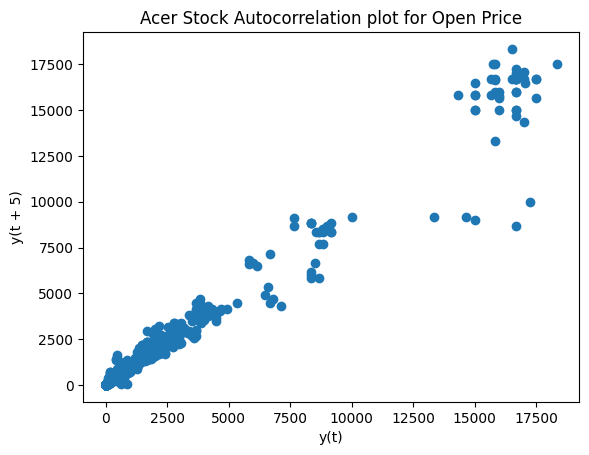

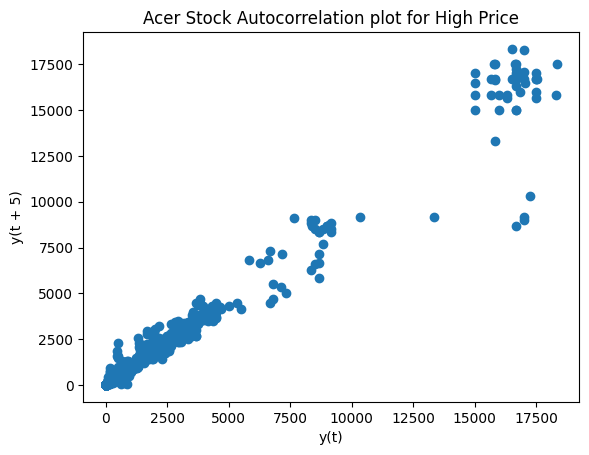

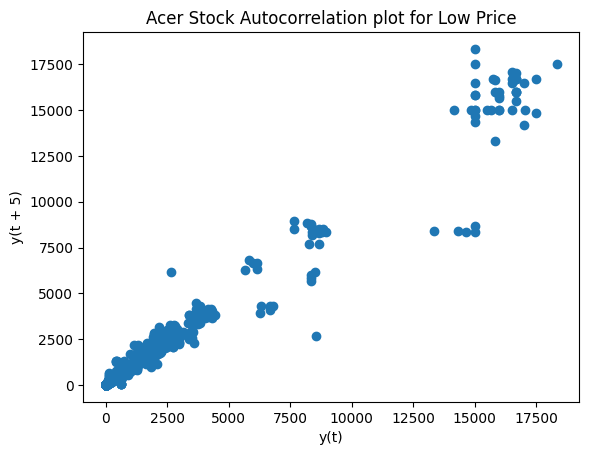

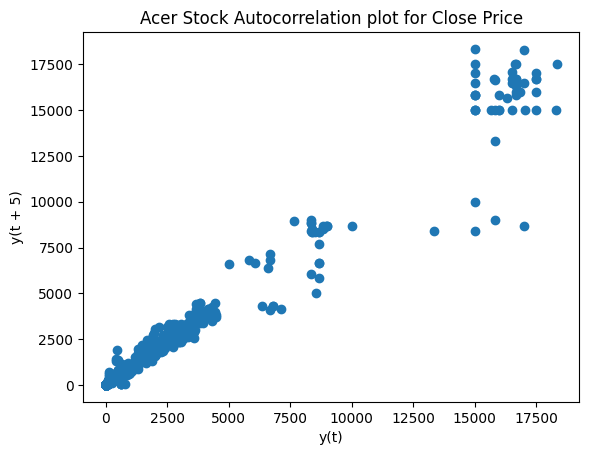

In [16]:
for i in imp_col:
    lag_plot(df[i], lag=5)
    plt.title('Acer Stock Autocorrelation plot for '+i+' Price')
    plt.show()

## SRIMA Model for Time Series Prediction

In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,17000.00,17000.00,17000.00,17000.00,0,0
1,2005-02-28,16666.67,17500.00,16666.67,17500.00,1,0
2,2005-03-01,16833.33,16833.33,16500.00,16500.00,1,0
3,2005-03-02,15000.00,16333.33,15000.00,15000.00,0,0
4,2005-03-03,15833.33,16833.33,15833.33,16833.33,1,0


In [18]:
df = df.reset_index()
df = df.set_index('Date')
df.head()

,index,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,,
2005-02-25,0,17000.00,17000.00,17000.00,17000.00,0,0
2005-02-28,1,16666.67,17500.00,16666.67,17500.00,1,0
2005-03-01,2,16833.33,16833.33,16500.00,16500.00,1,0
2005-03-02,3,15000.00,16333.33,15000.00,15000.00,0,0
2005-03-03,4,15833.33,16833.33,15833.33,16833.33,1,0


### Opening Price

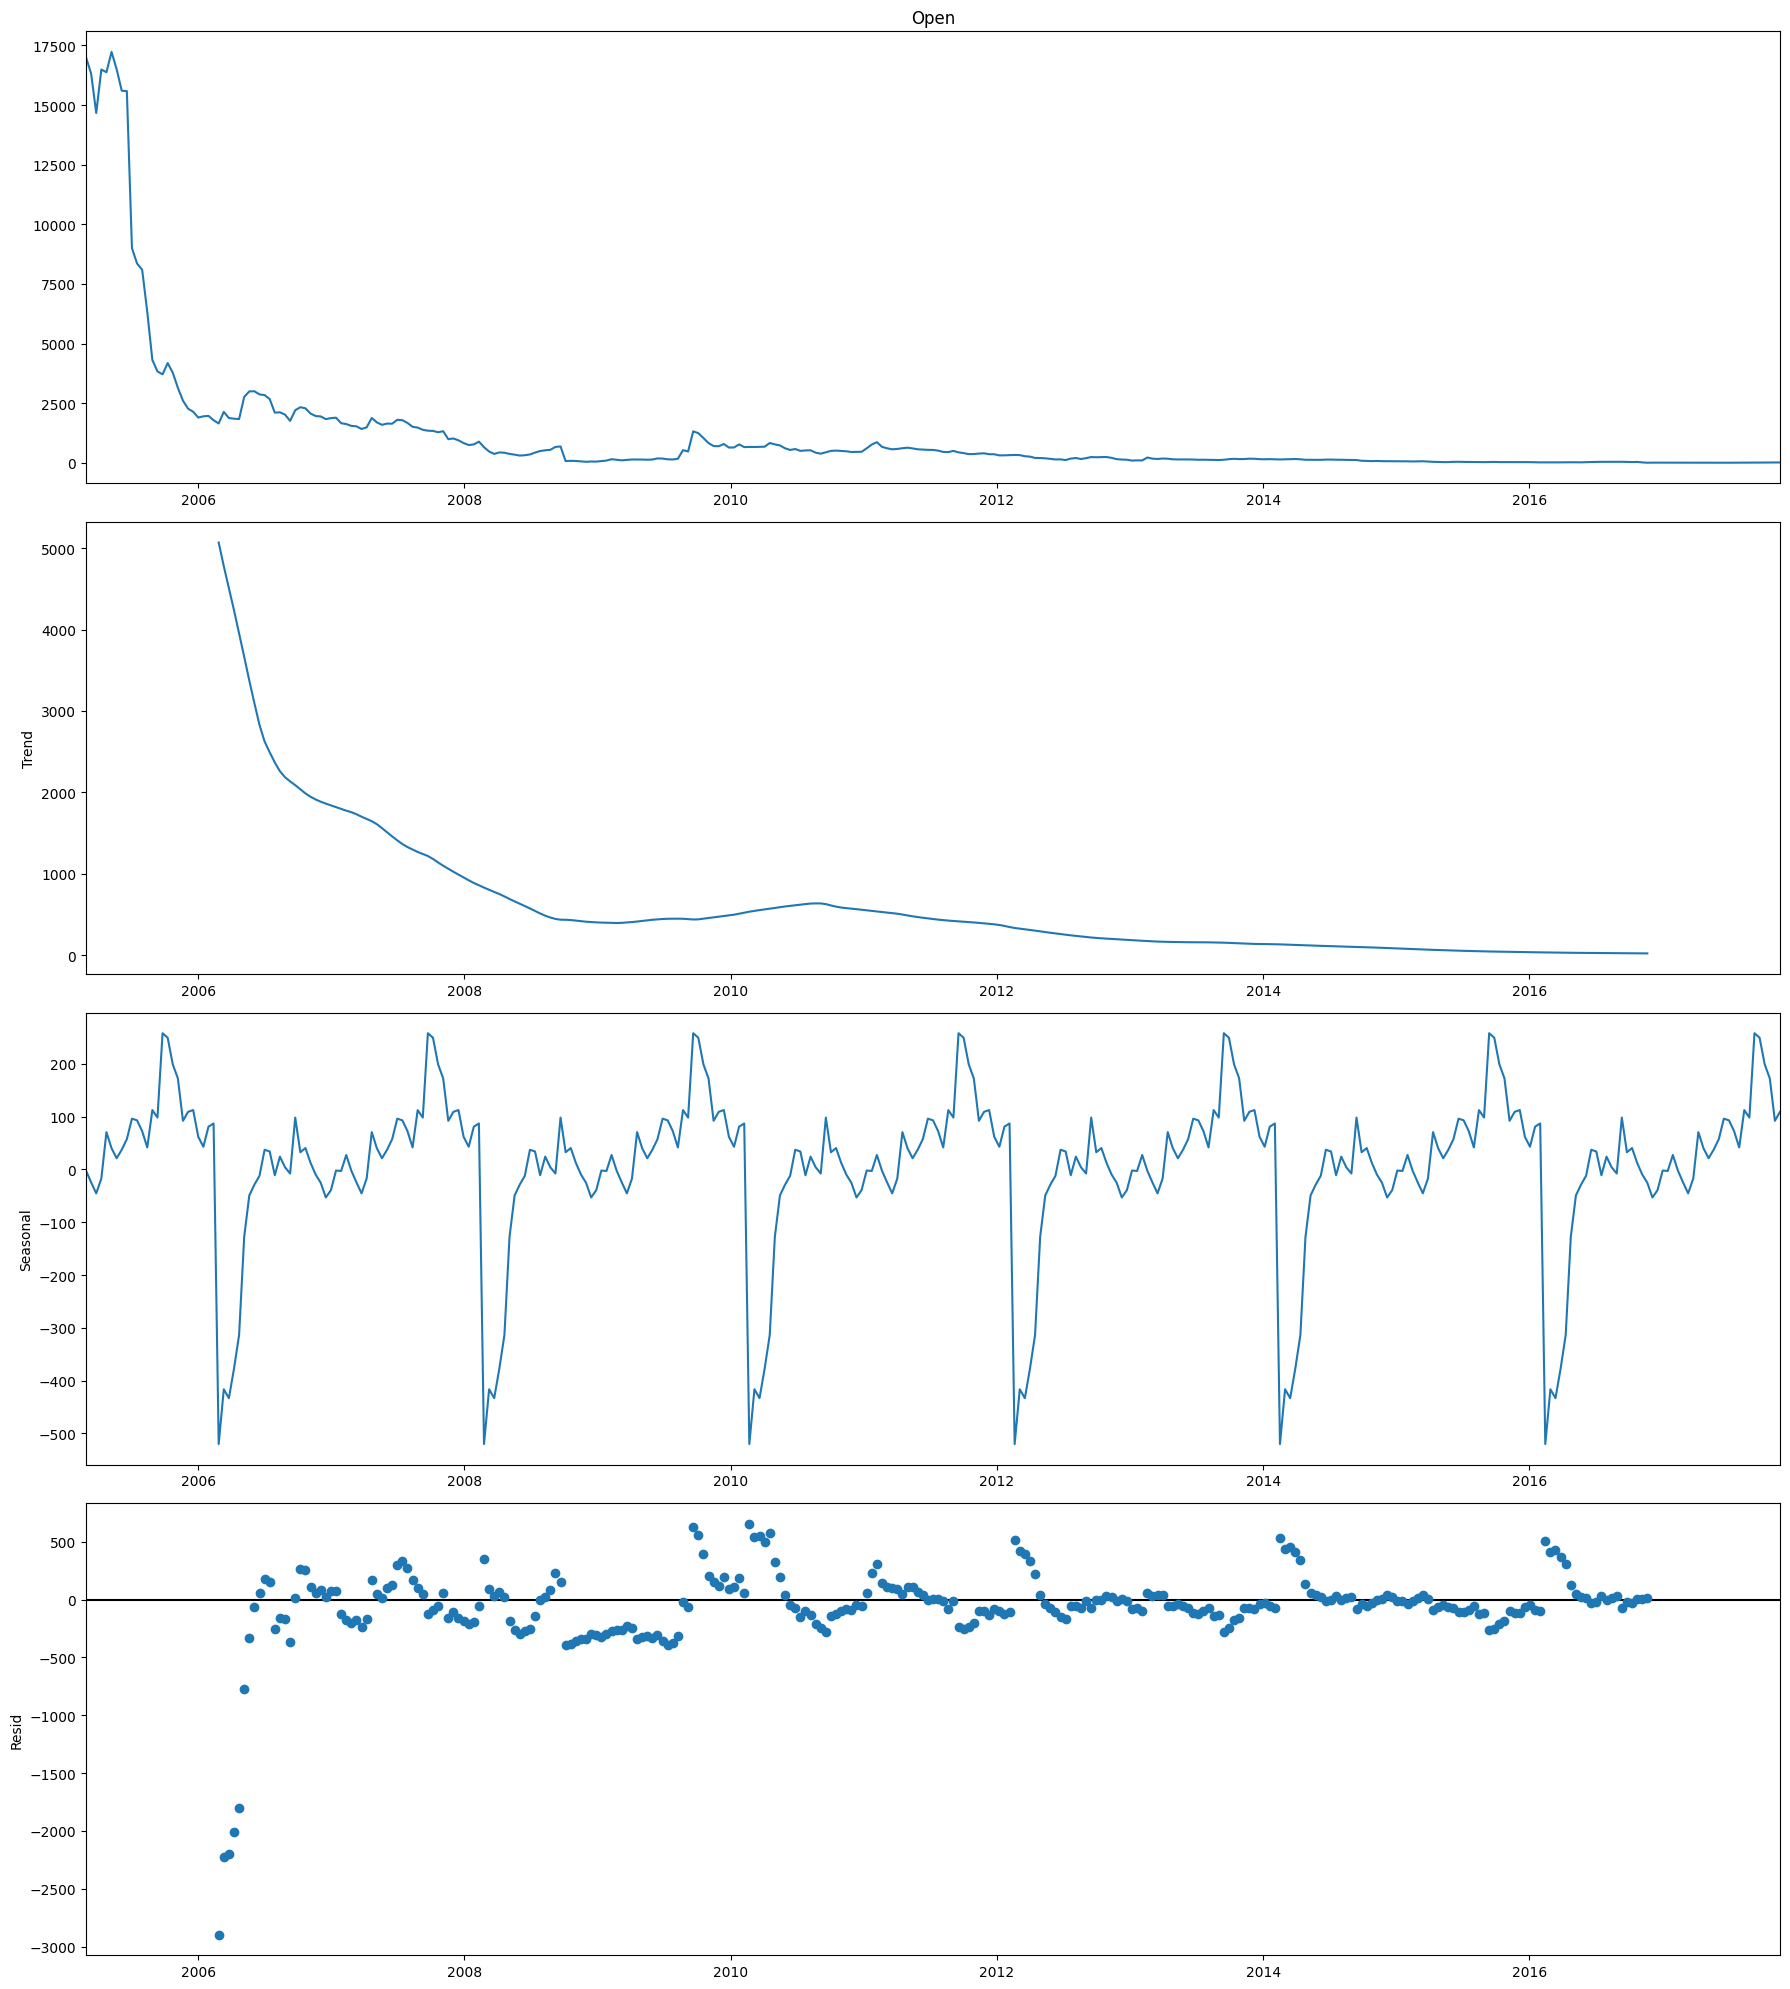

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50982D+00    |proj g|=  1.38672D-01

At iterate    5    f=  6.50150D+00    |proj g|=  8.81387D-03


 This problem is unconstrained.



At iterate   10    f=  6.50015D+00    |proj g|=  3.73251D-02

At iterate   15    f=  6.49804D+00    |proj g|=  2.37123D-02

At iterate   20    f=  6.49775D+00    |proj g|=  5.40176D-03

At iterate   25    f=  6.49765D+00    |proj g|=  1.90088D-02

At iterate   30    f=  6.48752D+00    |proj g|=  3.89272D-01

At iterate   35    f=  6.22444D+00    |proj g|=  1.11939D+00

At iterate   40    f=  6.09129D+00    |proj g|=  1.81428D-02
  ys=-1.077E-02  -gs= 1.428E-03 BFGS update SKIPPED

At iterate   45    f=  6.05758D+00    |proj g|=  4.81030D-01

At iterate   50    f=  6.05334D+00    |proj g|=  1.81929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

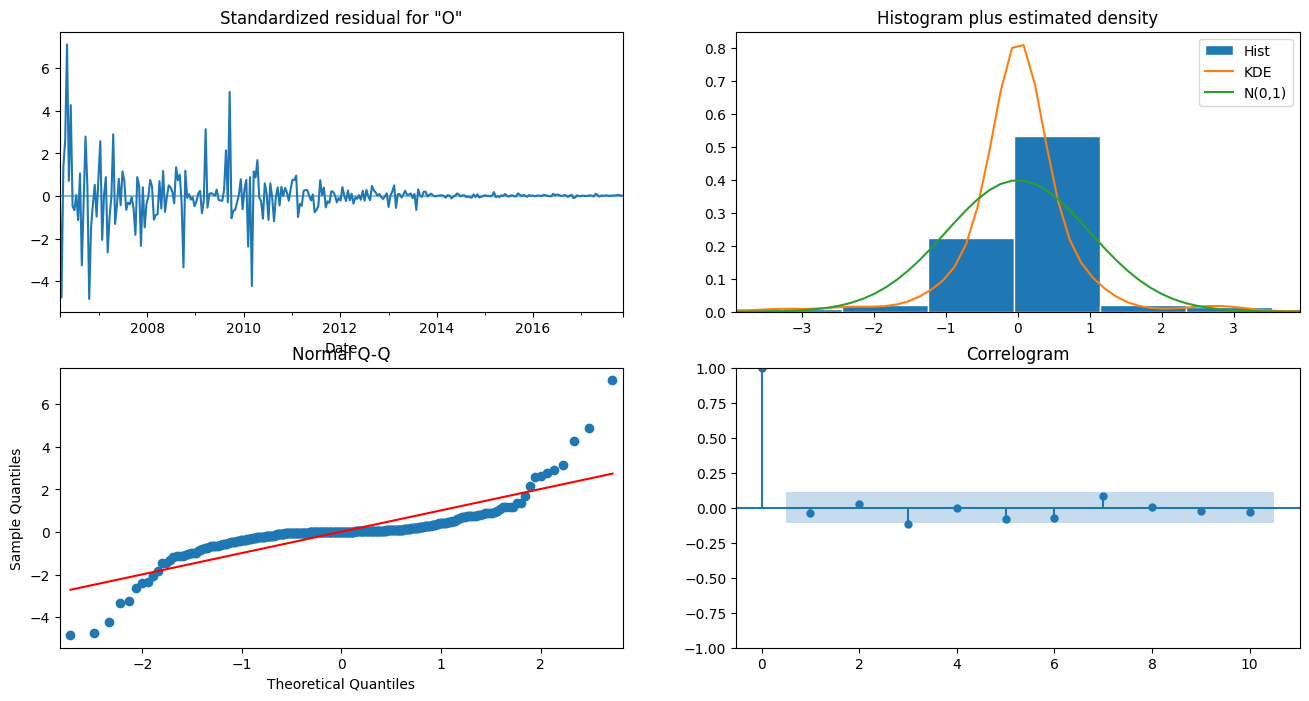

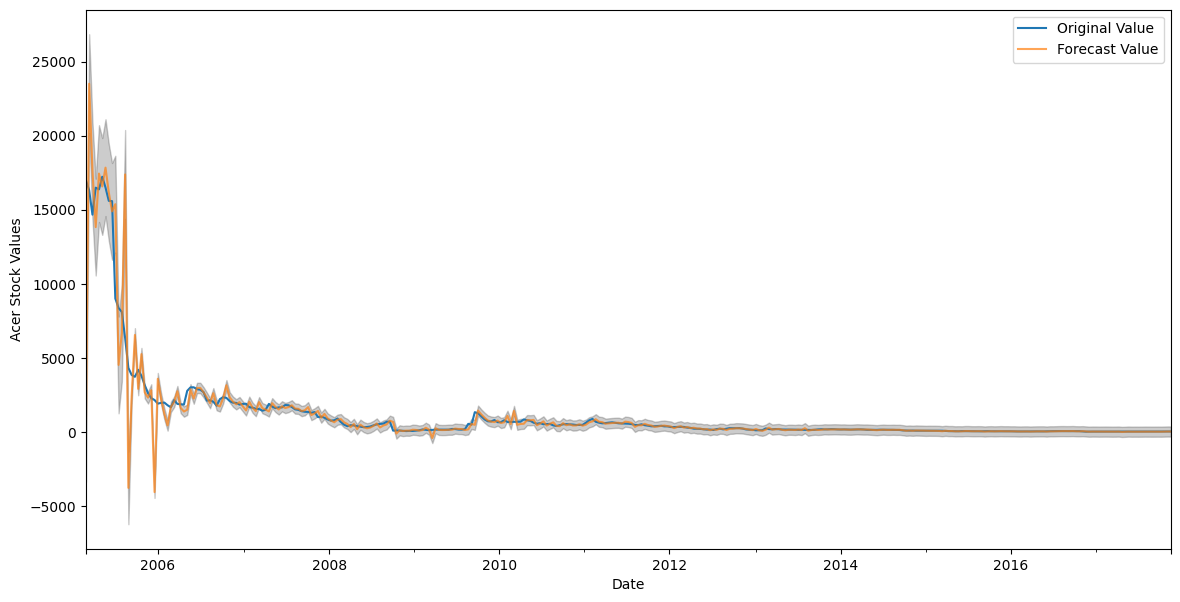

NameError: name 'forecast_accuracy' is not defined

In [19]:
t = df['Open'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))


# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

### Closing Price

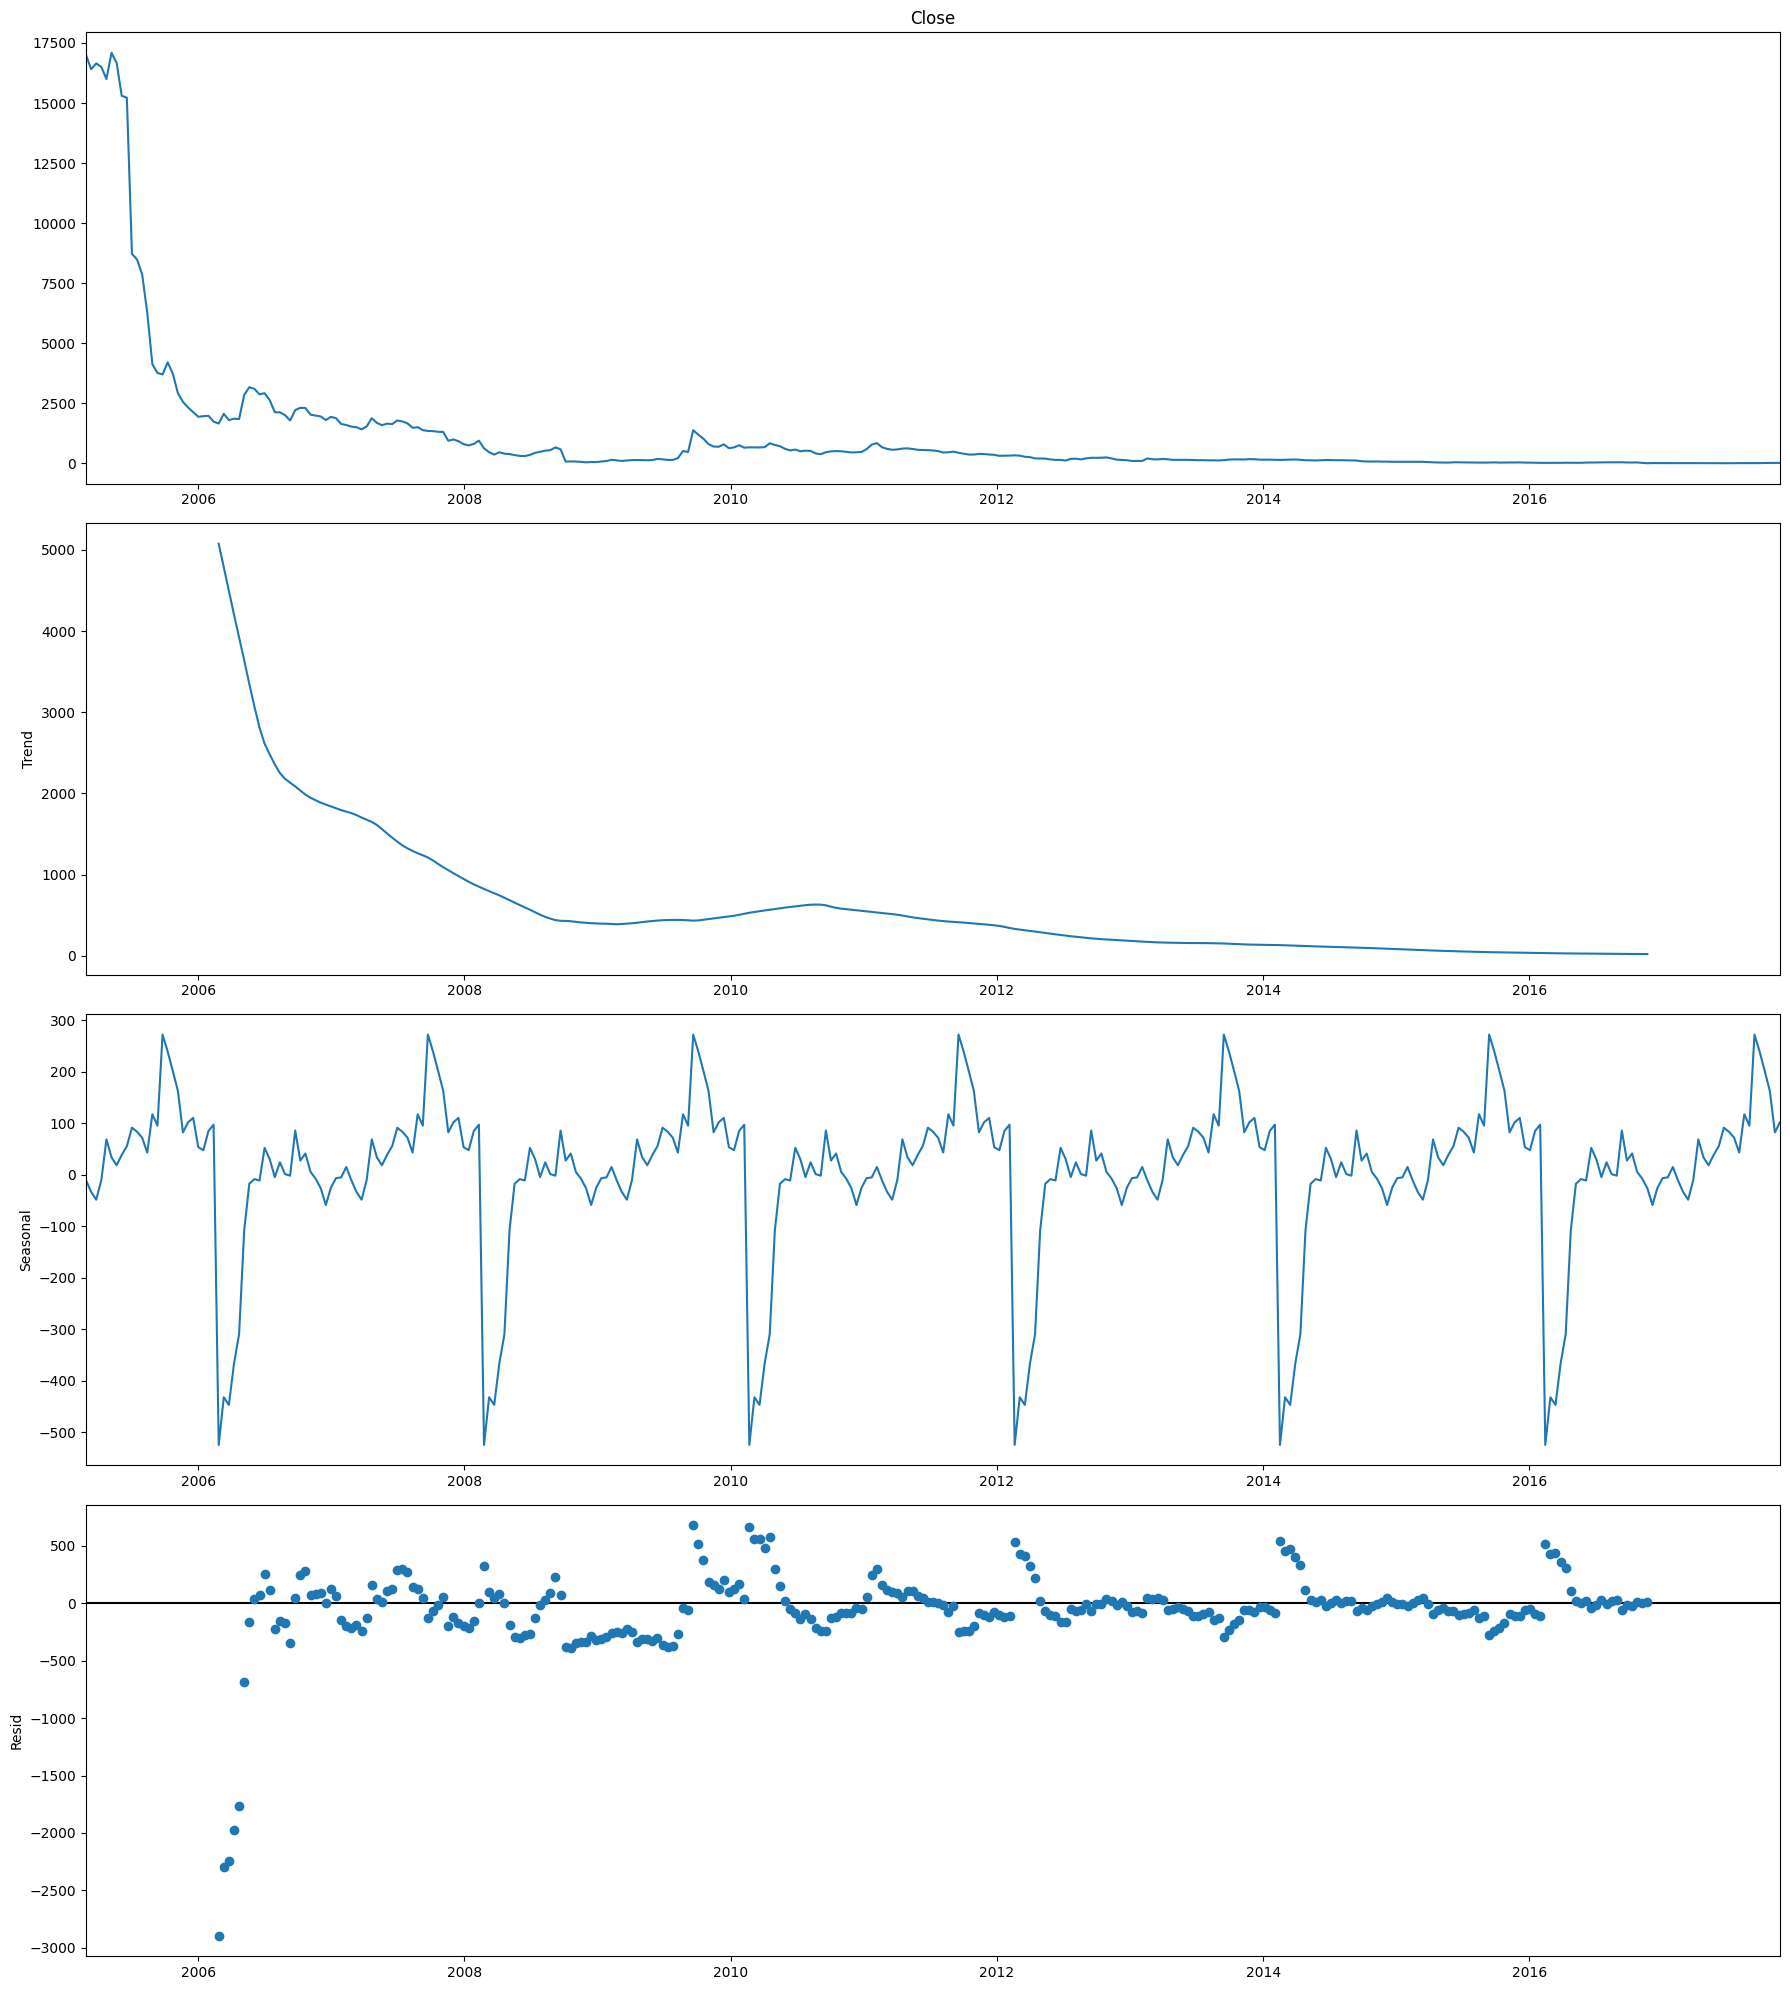

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50808D+00    |proj g|=  4.30745D-02

At iterate    5    f=  6.50441D+00    |proj g|=  2.12262D-03

At iterate   10    f=  6.50356D+00    |proj g|=  4.73411D-02


 This problem is unconstrained.



At iterate   15    f=  6.49951D+00    |proj g|=  1.24046D-01

At iterate   20    f=  6.49836D+00    |proj g|=  1.76708D-03

At iterate   25    f=  6.49794D+00    |proj g|=  3.17023D-02

At iterate   30    f=  6.42206D+00    |proj g|=  5.46021D-01

At iterate   35    f=  6.07369D+00    |proj g|=  2.71298D-01

At iterate   40    f=  6.06573D+00    |proj g|=  8.95928D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     65      1     0     0   4.084D-05   6.066D+00
  F =   6.0657276669476072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>

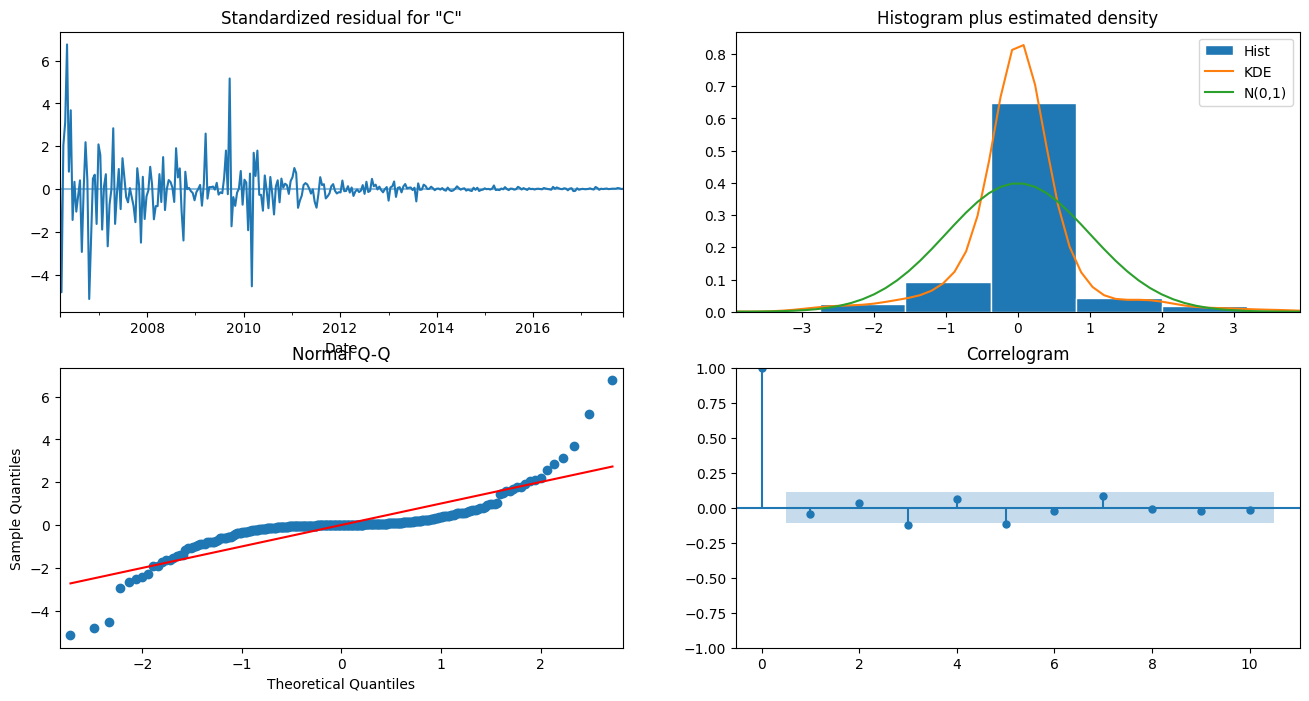

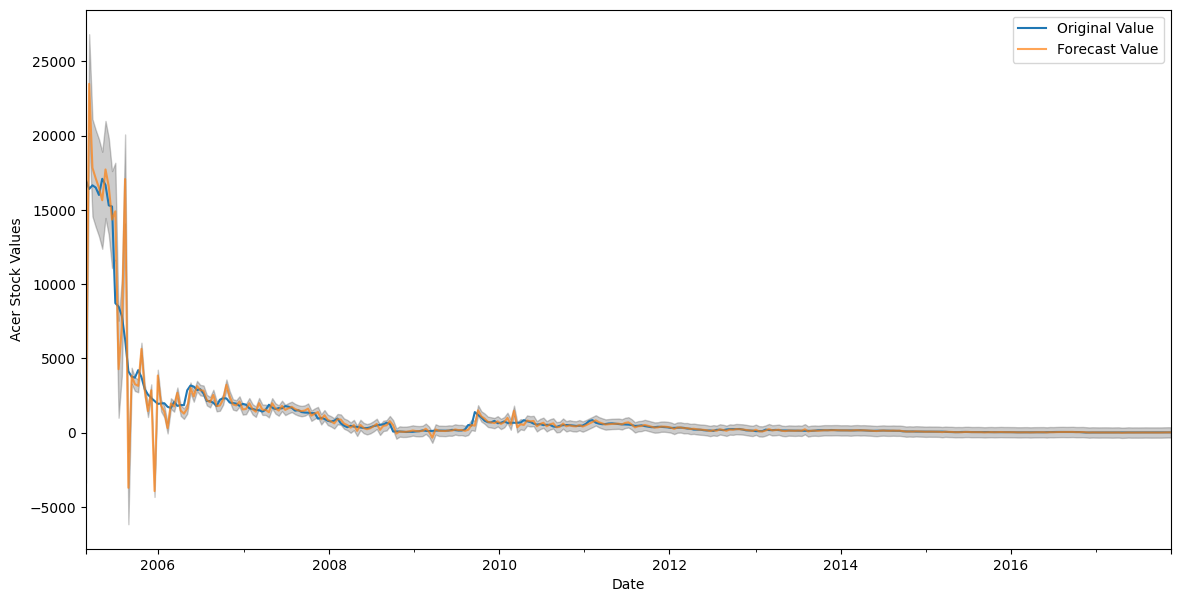

NameError: name 'forecast_accuracy' is not defined

In [20]:
t = df['Close'].resample('2W').mean()
rcParams['figure.figsize'] = 18, 20
decomposition = sm.tsa.seasonal_decompose(t, model='additive')
fig1 = decomposition.plot()
plt.show()

mod = sm.tsa.statespace.SARIMAX(t,
                                order=(2, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

pred = results.get_prediction(start=pd.to_datetime('2005-02-27'), dynamic=False)
pred_ci = pred.conf_int()
ax = t.plot(label='Original Value')
pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

forecast_accuracy(np.array(list(t)),np.array(list(y_forecasted)))

# Forecasting for next 3 Years
pred_uc = results.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()
ax = t.plot(label='Original Value', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Acer Stock Values')
plt.legend()
plt.show()

## ARIMA Model for Time Series Prediction

### Opening Prices

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  333
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2485.866
Date:                Sun, 30 Apr 2023   AIC                           4979.733
Time:                        20:02:39   BIC                           4994.953
Sample:                    02-27-2005   HQIC                          4985.803
                         - 11-19-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6735      0.097      6.963      0.000       0.484       0.863
ar.L2          0.1036      0.034      3.067      0.002       0.037       0.170
ma.L1         -0.6360      0.098     -6.502      0.0

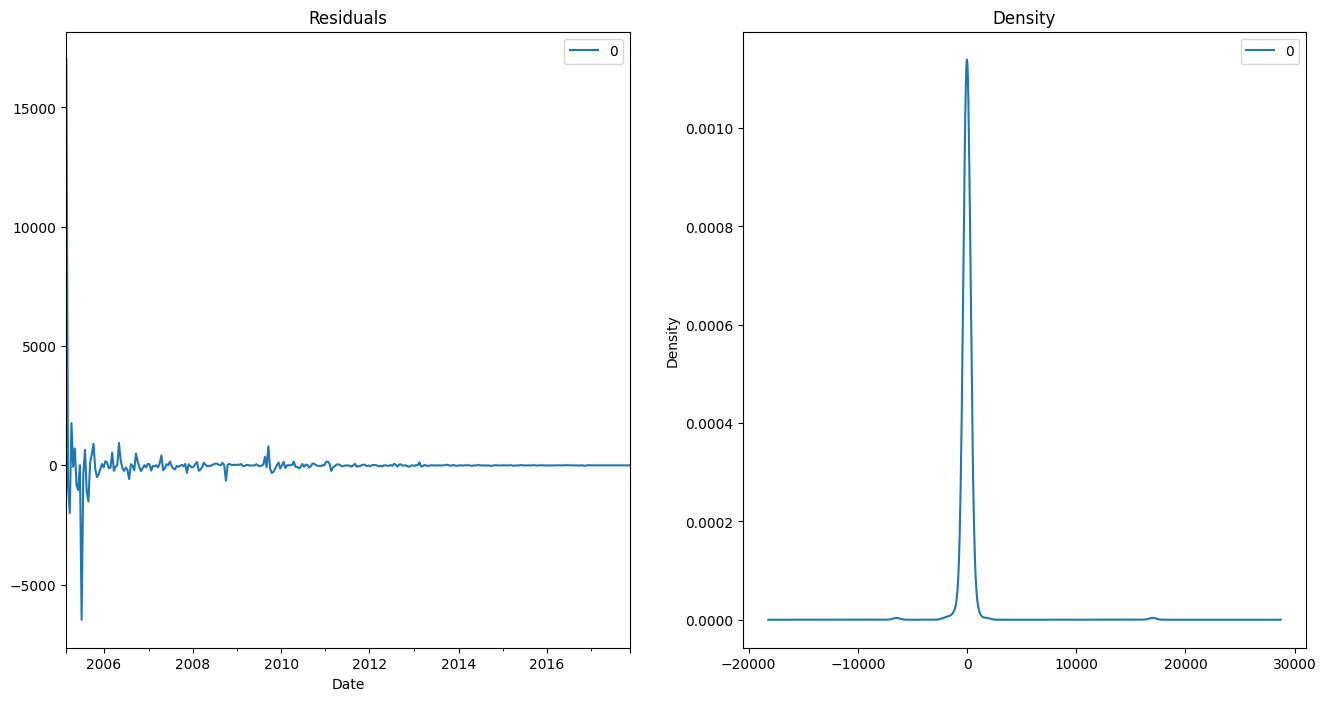

<Figure size 1600x800 with 0 Axes>

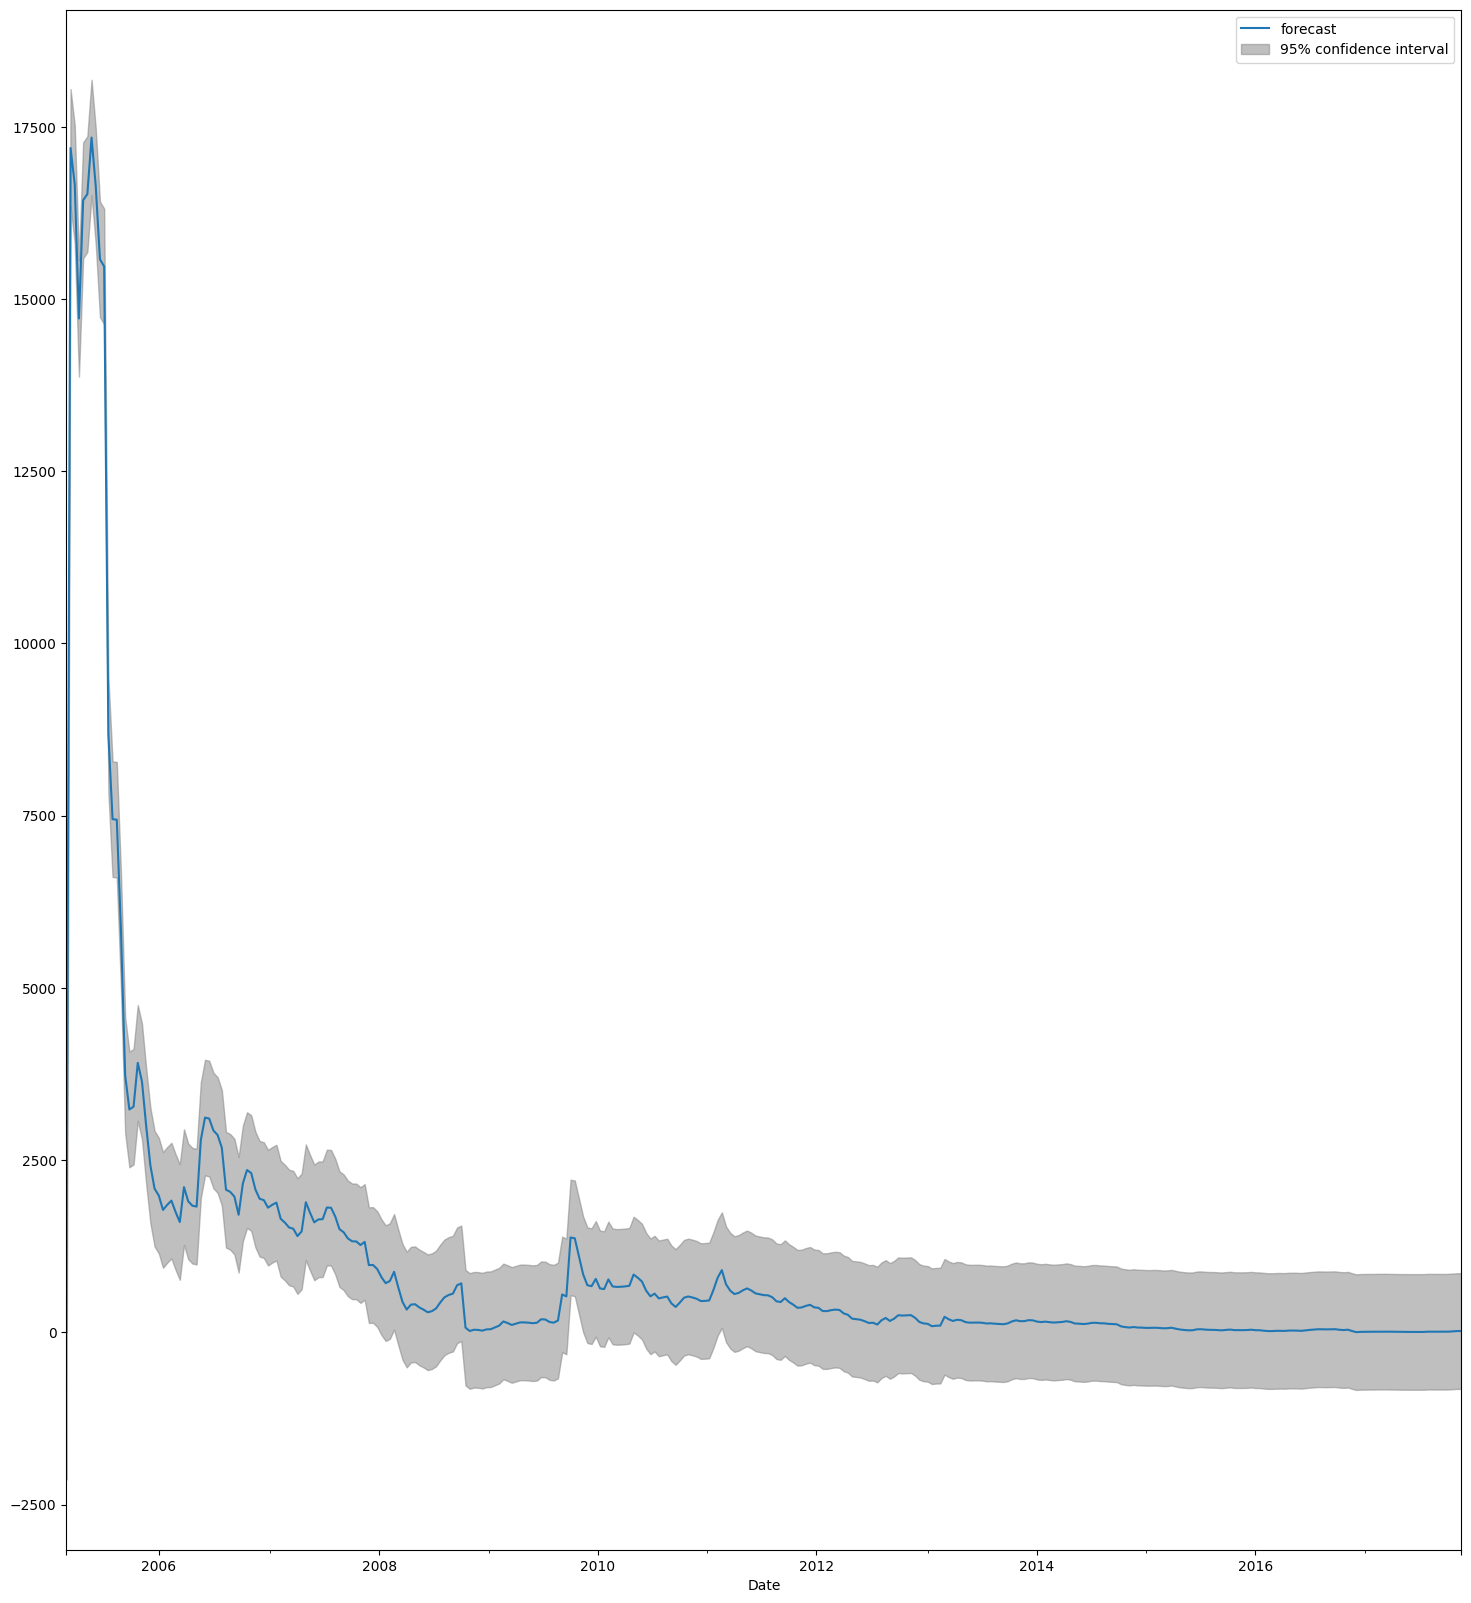

In [31]:
t = df['Open'].resample('2W').mean()

mod = ARIMA(t,order=(2, 1, 1))
results = mod.fit()
print(results.summary())

# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2,figsize=(16, 8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


# Actual vs Fitted
plt.figure(figsize=(16, 8))
plot_predict(results)
plt.show()

In [ ]:
# Acer  --> SARIMA  -> openn ,close , high , low
# --> ARIMA  -> openn ,close , high , low


## Deep learning Model : LSTM

### Closing price

In [9]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [10]:
scaled_data.shape

(3125, 1)

In [11]:
# how many days do i want to base my predictions on ?
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)


(3065, 60)
(3065, 60, 1)


In [12]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [13]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

2023-05-05 22:34:19.117029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 22:34:19.118821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 22:34:19.120044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

2023-05-05 22:34:19.650405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 22:34:19.651592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 22:34:19.653411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=2, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/2


2023-05-05 22:34:22.244667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 22:34:22.246865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 22:34:22.248154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

96/96 [==============================] - 10s 50ms/step - loss: 4.3714e-04
Epoch 2/2
96/96 [==============================] - 4s 43ms/step - loss: 1.5516e-04


In [15]:
y_pred = model.predict(x_train)
y_pred.shape

2023-05-05 22:34:36.676687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-05 22:34:36.679117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-05 22:34:36.680616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

96/96 [==============================] - 2s 12ms/step


(3065, 1)

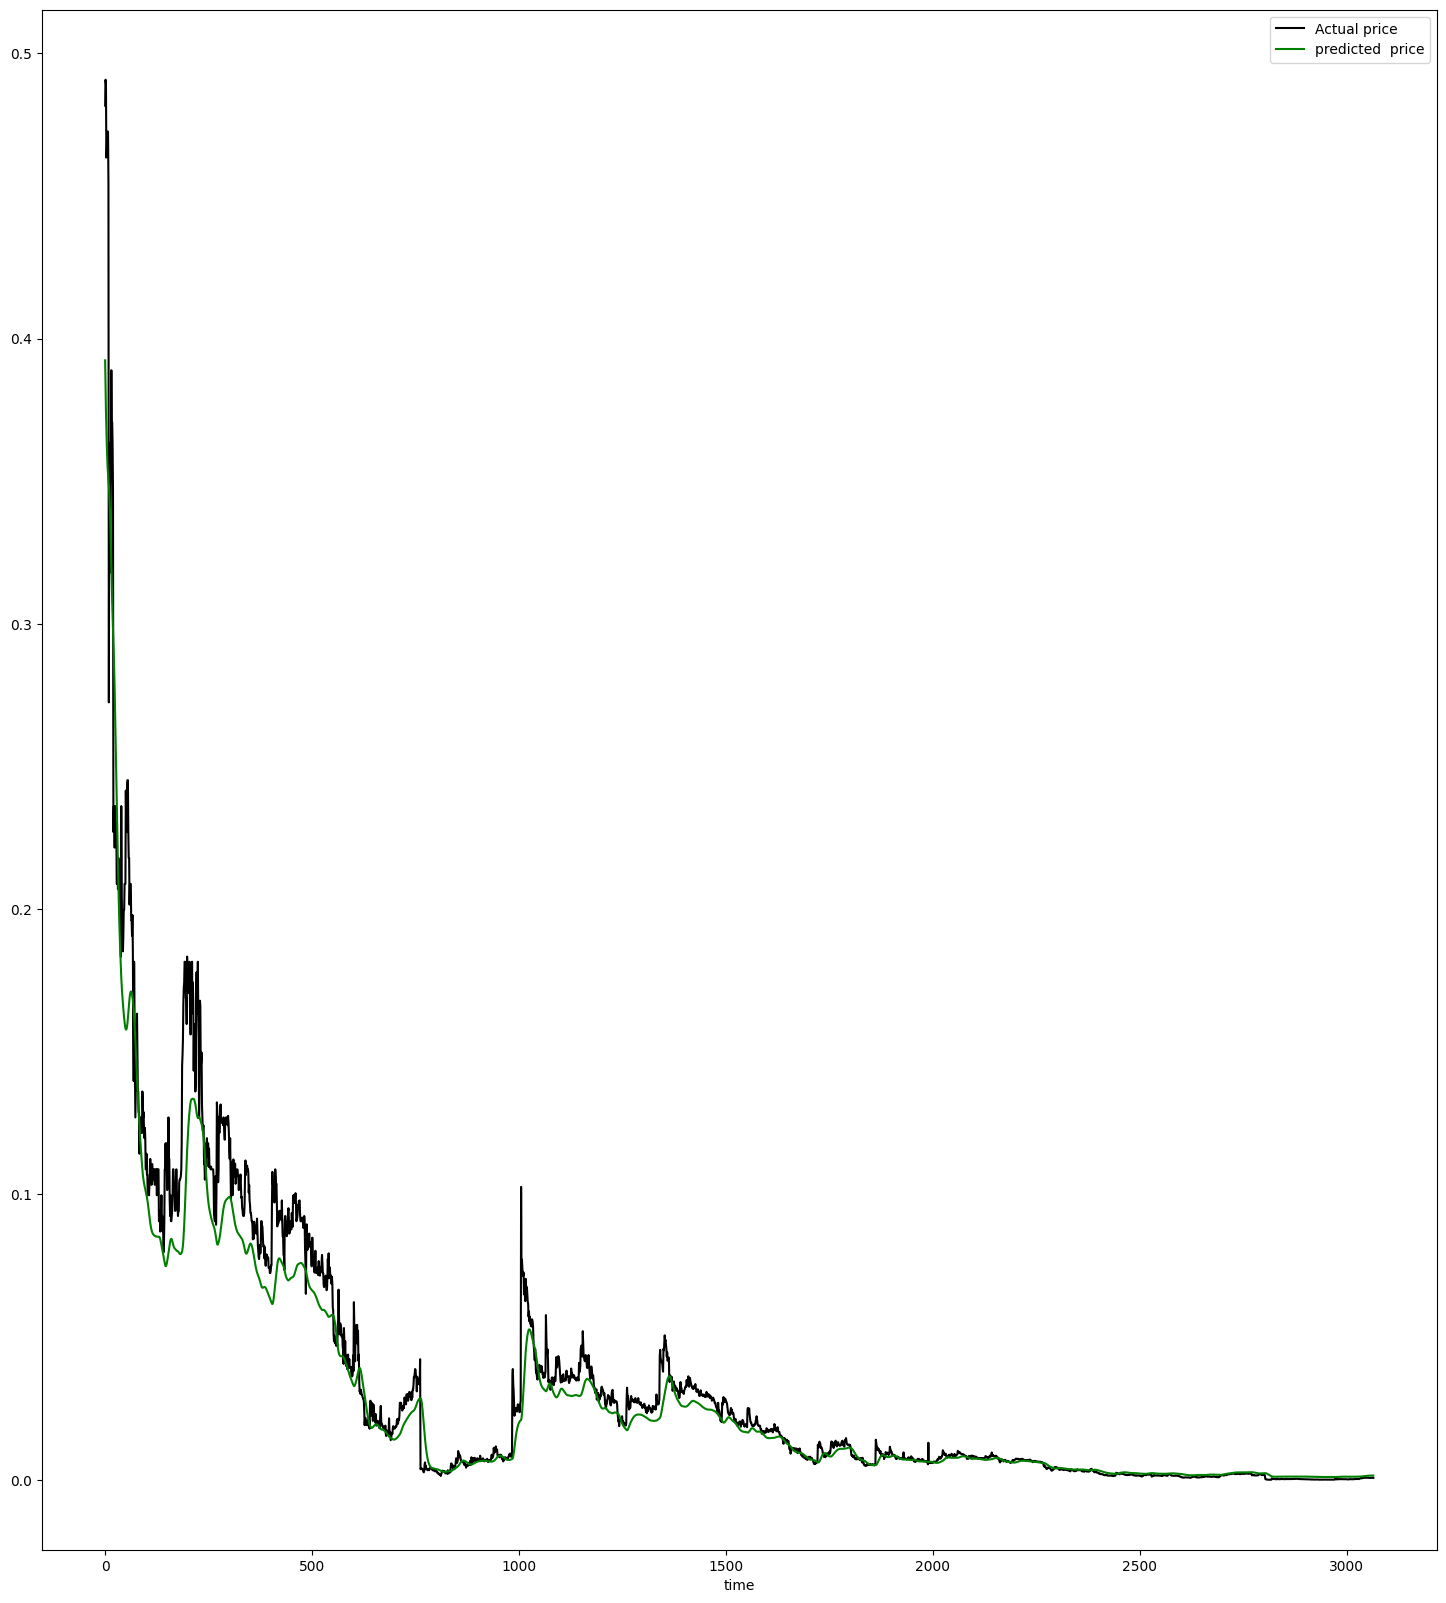

In [40]:
plt.plot(y_train, color='black', label="Actual price")
plt.plot(y_pred, color= 'green', label="predicted  price")
plt.xlabel("time")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import r2_score
amodel.compile(loss='mse', optimizer='rmsprop', metrics=[r2_score], run_eagerly=True)

In [31]:
forecast_accuracy(y_pred, y_train)

{'mape': inf, 'me': 0.002322013145678345, 'mae': 0.006331215357675319, 'mpe': inf, 'rmse': 0.010710724897994083, 'corr': nan, 'minmax': 0.36823484102753623}


In [29]:
y_train = y_train.reshape(3065,1)

In [30]:
y_train

array([[0.4816561 ],
       [0.49075004],
       [0.48893147],
       ...,
       [0.00065029],
       [0.00063952],
       [0.00064279]])